In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

file_path = "Violence Against Women  Girls Data.csv" 
df = pd.read_csv(file_path) 

df['Survey Year'] = pd.to_datetime(df['Survey Year'], errors='coerce') 
df['Year'] = df['Survey Year'].dt.year 
df = df.drop(columns=['Survey Year']) 

demo_pivot = df.pivot_table( index=['RecordID', 'Country', 'Gender', 'Year', 'Question'], columns='Demographics Question', values='Demographics Response', aggfunc='first' ).reset_index() 
demo_pivot.columns.name = None 
demo_pivot = demo_pivot.drop(columns=['Question']) 

value_pivot = df.pivot_table( index=['RecordID', 'Country', 'Gender', 'Year'], columns='Question', values='Value', aggfunc='first' ).reset_index() 
value_pivot.columns.name = None 

full_df = pd.merge( demo_pivot, value_pivot, on=['RecordID', 'Country', 'Gender', 'Year'], how='left' ) 
full_df = full_df.drop(columns=['RecordID', 'Year', 'Country']) 

question_cols = value_pivot.columns[4:] 

predictor_cols = full_df.columns.difference(question_cols) 

full_df[predictor_cols] = full_df[predictor_cols].fillna(0) 
full_df[question_cols] = full_df[question_cols].fillna(0)

print("Dataset info:")
print(full_df.info())

print("\nFirst 5 rows of the dataset:")
print(full_df.head())

print("\nSummary statistics for numeric columns:")
print(full_df.describe())

print("\nValue counts for categorical columns:")
for col in full_df.select_dtypes(include='object').columns:
    print(f"\n{col}:\n{full_df[col].value_counts()}")


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Gender                                   840 non-null    object 
 1   Age                                      840 non-null    object 
 2   Education                                840 non-null    object 
 3   Employment                               840 non-null    object 
 4   Marital status                           840 non-null    object 
 5   Residence                                840 non-null    object 
 6   ... for at least one specific reason     840 non-null    float64
 7   ... if she argues with him               840 non-null    float64
 8   ... if she burns the food                840 non-null    float64
 9   ... if she goes out without telling him  840 non-null    float64
 10  ... if she neglects the children    

In [ ]:
def create_evenly_balanced_binary_target(values, desired_ratio=0.5, tolerance=0.05):
    """
    Converts continuous values into a binary target, trying to balance classes.
    - desired_ratio: fraction of 1s to target (e.g., 0.5 for roughly equal)
    - tolerance: acceptable deviation from desired ratio
    """
    sorted_vals = np.sort(values)
    n = len(values)
    
    target_idx = int(n * (1 - desired_ratio))
    threshold = sorted_vals[target_idx]
    
    binary = (values > threshold).astype(int)
    actual_ratio = binary.mean()
  
    step = (sorted_vals[-1] - sorted_vals[0]) * 0.01  
    max_iter = 100
    iter_count = 0
    
    while (actual_ratio < desired_ratio - tolerance or actual_ratio > desired_ratio + tolerance) and iter_count < max_iter:
        if actual_ratio < desired_ratio - tolerance:
            threshold -= step
        elif actual_ratio > desired_ratio + tolerance:
            threshold += step
        binary = (values > threshold).astype(int)
        actual_ratio = binary.mean()
        iter_count += 1

    return binary, threshold
y_binary = pd.DataFrame(index=full_df.index, columns=question_cols)
thresholds = {}

for q in question_cols:
    y_binary[q], thresholds[q] = create_evenly_balanced_binary_target(full_df[q].values)
    print(f"{q} → Threshold: {thresholds[q]:.2f}, Class balance: {y_binary[q].mean():.2f}")

categorical_cols = full_df[predictor_cols].select_dtypes(include='object').columns.tolist()
numeric_cols = full_df[predictor_cols].select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


... for at least one specific reason → Threshold: 0.00, Class balance: 0.15
... if she argues with him → Threshold: 0.00, Class balance: 0.15
... if she burns the food → Threshold: 0.00, Class balance: 0.14
... if she goes out without telling him → Threshold: 0.00, Class balance: 0.15
... if she neglects the children → Threshold: 0.00, Class balance: 0.15
... if she refuses to have sex with him → Threshold: 0.00, Class balance: 0.15


In [ ]:
def create_balanced_binary_target(values, min_ratio=0.2, max_ratio=0.8):
    threshold = 50  
    binary = (values > threshold).astype(int)
    
    ratio = binary.mean()
    if ratio < min_ratio or ratio > max_ratio:
        threshold = np.median(values)
        binary = (values > threshold).astype(int)
        ratio = binary.mean()
 
    if ratio < min_ratio:
        threshold = np.percentile(values, 30)
        binary = (values > threshold).astype(int)
    elif ratio > max_ratio:
        threshold = np.percentile(values, 70)
        binary = (values > threshold).astype(int)
    
    return binary, threshold
y_binary = pd.DataFrame(index=full_df.index, columns=question_cols)
thresholds = {}

for q in question_cols:
    y_binary[q], thresholds[q] = create_balanced_binary_target(full_df[q].values)
    print(f"{q} → Threshold: {thresholds[q]:.2f}, Class balance: {y_binary[q].mean():.2f}")

categorical_cols = full_df[predictor_cols].select_dtypes(include='object').columns.tolist()
numeric_cols = full_df[predictor_cols].select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


... for at least one specific reason → Threshold: 0.00, Class balance: 0.15
... if she argues with him → Threshold: 0.00, Class balance: 0.15
... if she burns the food → Threshold: 0.00, Class balance: 0.14
... if she goes out without telling him → Threshold: 0.00, Class balance: 0.15
... if she neglects the children → Threshold: 0.00, Class balance: 0.15
... if she refuses to have sex with him → Threshold: 0.00, Class balance: 0.15


In [ ]:
def create_binary_target(values, initial_thresh=50):
    threshold = initial_thresh
    binary = (values > threshold).astype(int)
    if len(np.unique(binary)) < 2:
        for perc in [30, 70]:
            threshold = np.percentile(values, perc)
            binary = (values > threshold).astype(int)
            if len(np.unique(binary)) > 1:
                break

    if len(np.unique(binary)) < 2:
        threshold = np.min(values) + 1e-6
        binary = (values > threshold).astype(int)
    
    return binary, threshold

y_binary = pd.DataFrame(index=full_df.index, columns=question_cols)
thresholds = {}

for q in question_cols:
    y_binary[q], thresholds[q] = create_binary_target(full_df[q].values)

categorical_cols = full_df[predictor_cols].select_dtypes(include='object').columns.tolist()
numeric_cols = full_df[predictor_cols].select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results_list = []

for q in question_cols:
    X = full_df[predictor_cols]
    y = y_binary[q]

    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42
        )

    model_pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('logreg', LogisticRegression(max_iter=500, class_weight='balanced'))
    ])

    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    y_proba = model_pipeline.predict_proba(X_test)[:,1]
  
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(y_test, y_proba)
    except ValueError:
        roc_auc = np.nan  
        
    num_features = numeric_cols
    cat_features = model_pipeline.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names = np.concatenate([num_features, cat_features])
    coefficients = model_pipeline.named_steps['logreg'].coef_.flatten()

    results_list.append({
        'question': q,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'threshold_used': thresholds[q],
        'feature_names': feature_names,
        'coefficients': coefficients,
        'y_pred': y_pred
    })

results_df = pd.DataFrame(results_list)

print("\nClassification metrics for each question:")
print(results_df[['question','accuracy','precision','recall','f1_score','roc_auc']])

print("\nTarget balance for all questions:")
for q in question_cols:
    counts = y_binary[q].value_counts()
    ratio = y_binary[q].mean()  # fraction of 1s
    print(f"{q} → 0s: {counts.get(0,0)}, 1s: {counts.get(1,0)}, fraction of 1s: {ratio:.2f}")

    


Classification metrics for each question:
                                  question  accuracy  precision    recall  \
0     ... for at least one specific reason  0.228571   0.164948  1.000000   
1               ... if she argues with him  0.514286   0.161905  0.548387   
2                ... if she burns the food  0.909524   0.812500  0.448276   
3  ... if she goes out without telling him  0.228571   0.164948  1.000000   
4         ... if she neglects the children  0.228571   0.164948  1.000000   
5  ... if she refuses to have sex with him  0.547619   0.180000  0.580645   

   f1_score   roc_auc  
0  0.283186  0.428195  
1  0.250000  0.548567  
2  0.577778  0.689084  
3  0.283186  0.428195  
4  0.283186  0.433813  
5  0.274809  0.580014  

Target balance for all questions:
... for at least one specific reason → 0s: 712, 1s: 128, fraction of 1s: 0.15
... if she argues with him → 0s: 716, 1s: 124, fraction of 1s: 0.15
... if she burns the food → 0s: 725, 1s: 115, fraction of 1s: 0.14
.

In [ ]:
def create_strictly_balanced_binary_target(values, desired_ratio=0.5):
    values = np.nan_to_num(values)
    sorted_vals = np.sort(values)
    n = len(values)
    target_idx = int(n * (1 - desired_ratio))
    threshold = sorted_vals[target_idx]
    binary = (values > threshold).astype(int)
    
    if binary.mean() == 0.0:
        threshold = sorted_vals[max(0, target_idx - 1)]
        binary = (values > threshold).astype(int)
    elif binary.mean() == 1.0:
        threshold = sorted_vals[min(n-1, target_idx + 1)]
        binary = (values > threshold).astype(int)
    
    return binary, threshold

y_binary = pd.DataFrame(index=full_df.index, columns=question_cols)
thresholds = {}

for q in question_cols:
    y_binary[q], thresholds[q] = create_strictly_balanced_binary_target(full_df[q].values)
    print(f"{q} → Threshold: {thresholds[q]:.2f}, Class balance: {y_binary[q].mean():.2f}")

categorical_cols = full_df[predictor_cols].select_dtypes(include='object').columns.tolist()
numeric_cols = full_df[predictor_cols].select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


... for at least one specific reason → Threshold: 0.00, Class balance: 0.15
... if she argues with him → Threshold: 0.00, Class balance: 0.15
... if she burns the food → Threshold: 0.00, Class balance: 0.14
... if she goes out without telling him → Threshold: 0.00, Class balance: 0.15
... if she neglects the children → Threshold: 0.00, Class balance: 0.15
... if she refuses to have sex with him → Threshold: 0.00, Class balance: 0.15


In [ ]:
def binary_from_mean(values):
    values = np.nan_to_num(values)  
    mean_val = np.mean(values)
    binary = (values > mean_val).astype(int)
    return binary, mean_val

y_binary = pd.DataFrame(index=full_df.index, columns=question_cols)
thresholds = {}

for q in question_cols:
    y_binary[q], thresholds[q] = binary_from_mean(full_df[q].values)
    print(f"{q} → Threshold (mean): {thresholds[q]:.2f}, Class balance: {y_binary[q].mean():.2f}")

categorical_cols = full_df[predictor_cols].select_dtypes(include='object').columns.tolist()
numeric_cols = full_df[predictor_cols].select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


... for at least one specific reason → Threshold (mean): 5.47, Class balance: 0.15
... if she argues with him → Threshold (mean): 3.00, Class balance: 0.13
... if she burns the food → Threshold (mean): 0.95, Class balance: 0.11
... if she goes out without telling him → Threshold (mean): 3.20, Class balance: 0.14
... if she neglects the children → Threshold (mean): 3.86, Class balance: 0.14
... if she refuses to have sex with him → Threshold (mean): 2.01, Class balance: 0.13


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results_list = []

for q in question_cols:
    X = full_df[predictor_cols]
    y = y_binary[q]

    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42
        )

    model_pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('logreg', LogisticRegression(max_iter=500, class_weight='balanced'))
    ])

    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    try:
        y_proba = model_pipeline.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_proba = np.full_like(y_pred, 0.5)  

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(y_test, y_proba)
    except ValueError:
        roc_auc = np.nan 
    num_features = numeric_cols
    cat_features = model_pipeline.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names = np.concatenate([num_features, cat_features])
    coefficients = model_pipeline.named_steps['logreg'].coef_.flatten()

    results_list.append({
        'question': q,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'threshold_used': thresholds[q],
        'feature_names': feature_names,
        'coefficients': coefficients,
        'y_pred': y_pred
    })

results_df = pd.DataFrame(results_list)

print("\nClassification metrics for each question:")
print(results_df[['question', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']])

print("\nTarget balance for all questions:")
for q in question_cols:
    counts = y_binary[q].value_counts()
    ratio = y_binary[q].mean()  # fraction of 1s
    print(f"{q} → 0s: {counts.get(0,0)}, 1s: {counts.get(1,0)}, fraction of 1s: {ratio:.2f}")



Classification metrics for each question:
                                  question  accuracy  precision    recall  \
0     ... for at least one specific reason  0.528571   0.144330  0.466667   
1               ... if she argues with him  0.542857   0.145833  0.500000   
2                ... if she burns the food  0.895238   0.538462  0.304348   
3  ... if she goes out without telling him  0.214286   0.149485  1.000000   
4         ... if she neglects the children  0.566667   0.164835  0.500000   
5  ... if she refuses to have sex with him  0.504762   0.111111  0.407407   

   f1_score   roc_auc  
0  0.220472  0.532500  
1  0.225806  0.546703  
2  0.388889  0.670774  
3  0.260090  0.606115  
4  0.247934  0.561111  
5  0.174603  0.489172  

Target balance for all questions:
... for at least one specific reason → 0s: 718, 1s: 122, fraction of 1s: 0.15
... if she argues with him → 0s: 727, 1s: 113, fraction of 1s: 0.13
... if she burns the food → 0s: 747, 1s: 93, fraction of 1s: 0.11
..

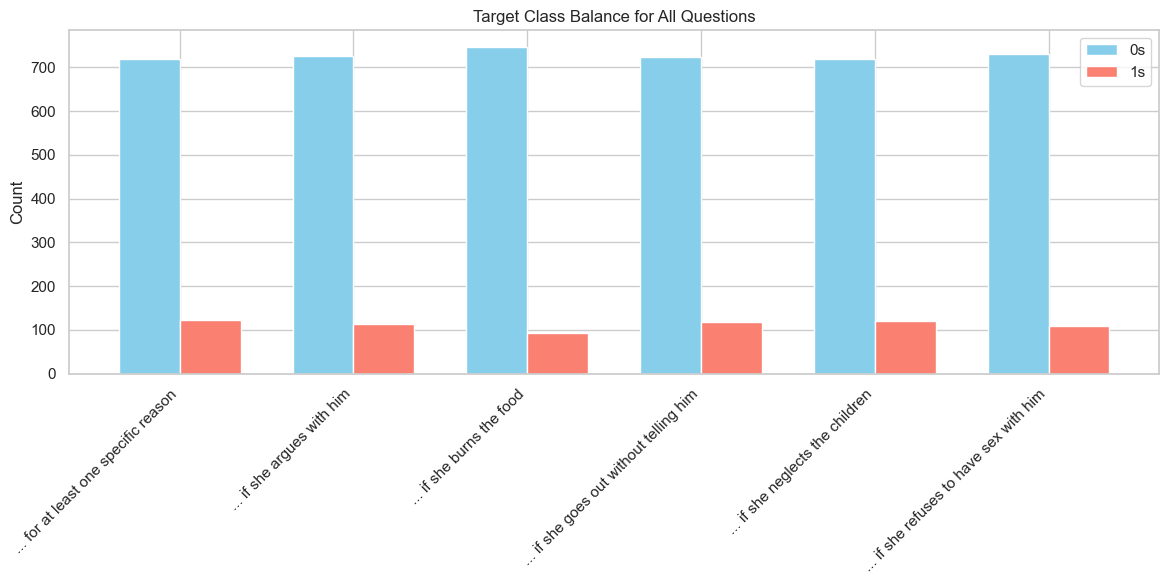

In [ ]:
import matplotlib.pyplot as plt

zeros = []
ones = []
questions = question_cols.tolist()

for q in questions:
    counts = y_binary[q].value_counts()
    zeros.append(counts.get(0, 0))
    ones.append(counts.get(1, 0))

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(questions))

ax.bar(x - bar_width/2, zeros, width=bar_width, label='0s', color='skyblue')
ax.bar(x + bar_width/2, ones, width=bar_width, label='1s', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels(questions, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Target Class Balance for All Questions')
ax.legend()

plt.tight_layout()
plt.show()

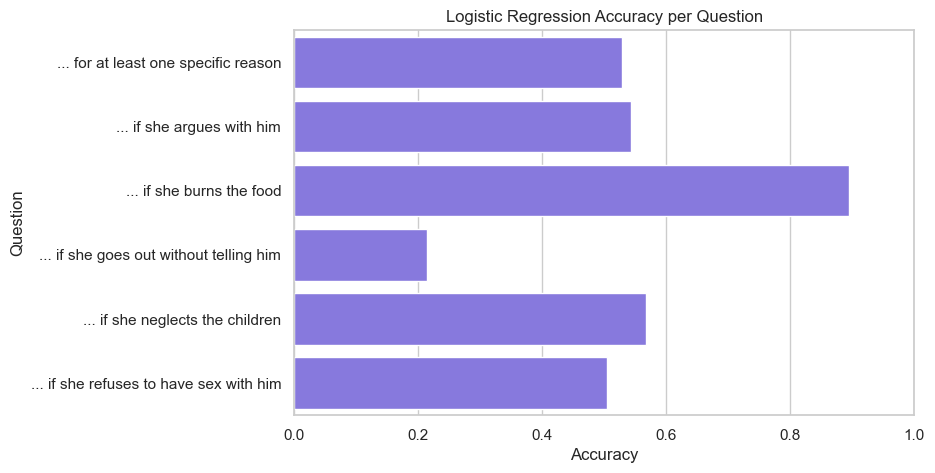

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(8,5))
sns.barplot(
    x='accuracy', 
    y='question', 
    data=results_df,
    color="mediumslateblue" 
)
plt.title("Logistic Regression Accuracy per Question")
plt.xlabel("Accuracy")
plt.ylabel("Question")
plt.xlim(0,1)
plt.show()




C:\Users\40723\AppData\Local\Temp\ipykernel_18164\534404363.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\40723\AppData\Local\Temp\ipykernel_18164\534404363.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\40723\AppData\Local\Temp\ipykernel_18164\534404363.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\40723\AppData\Local\Temp\ipykernel_18164\534404363.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` 

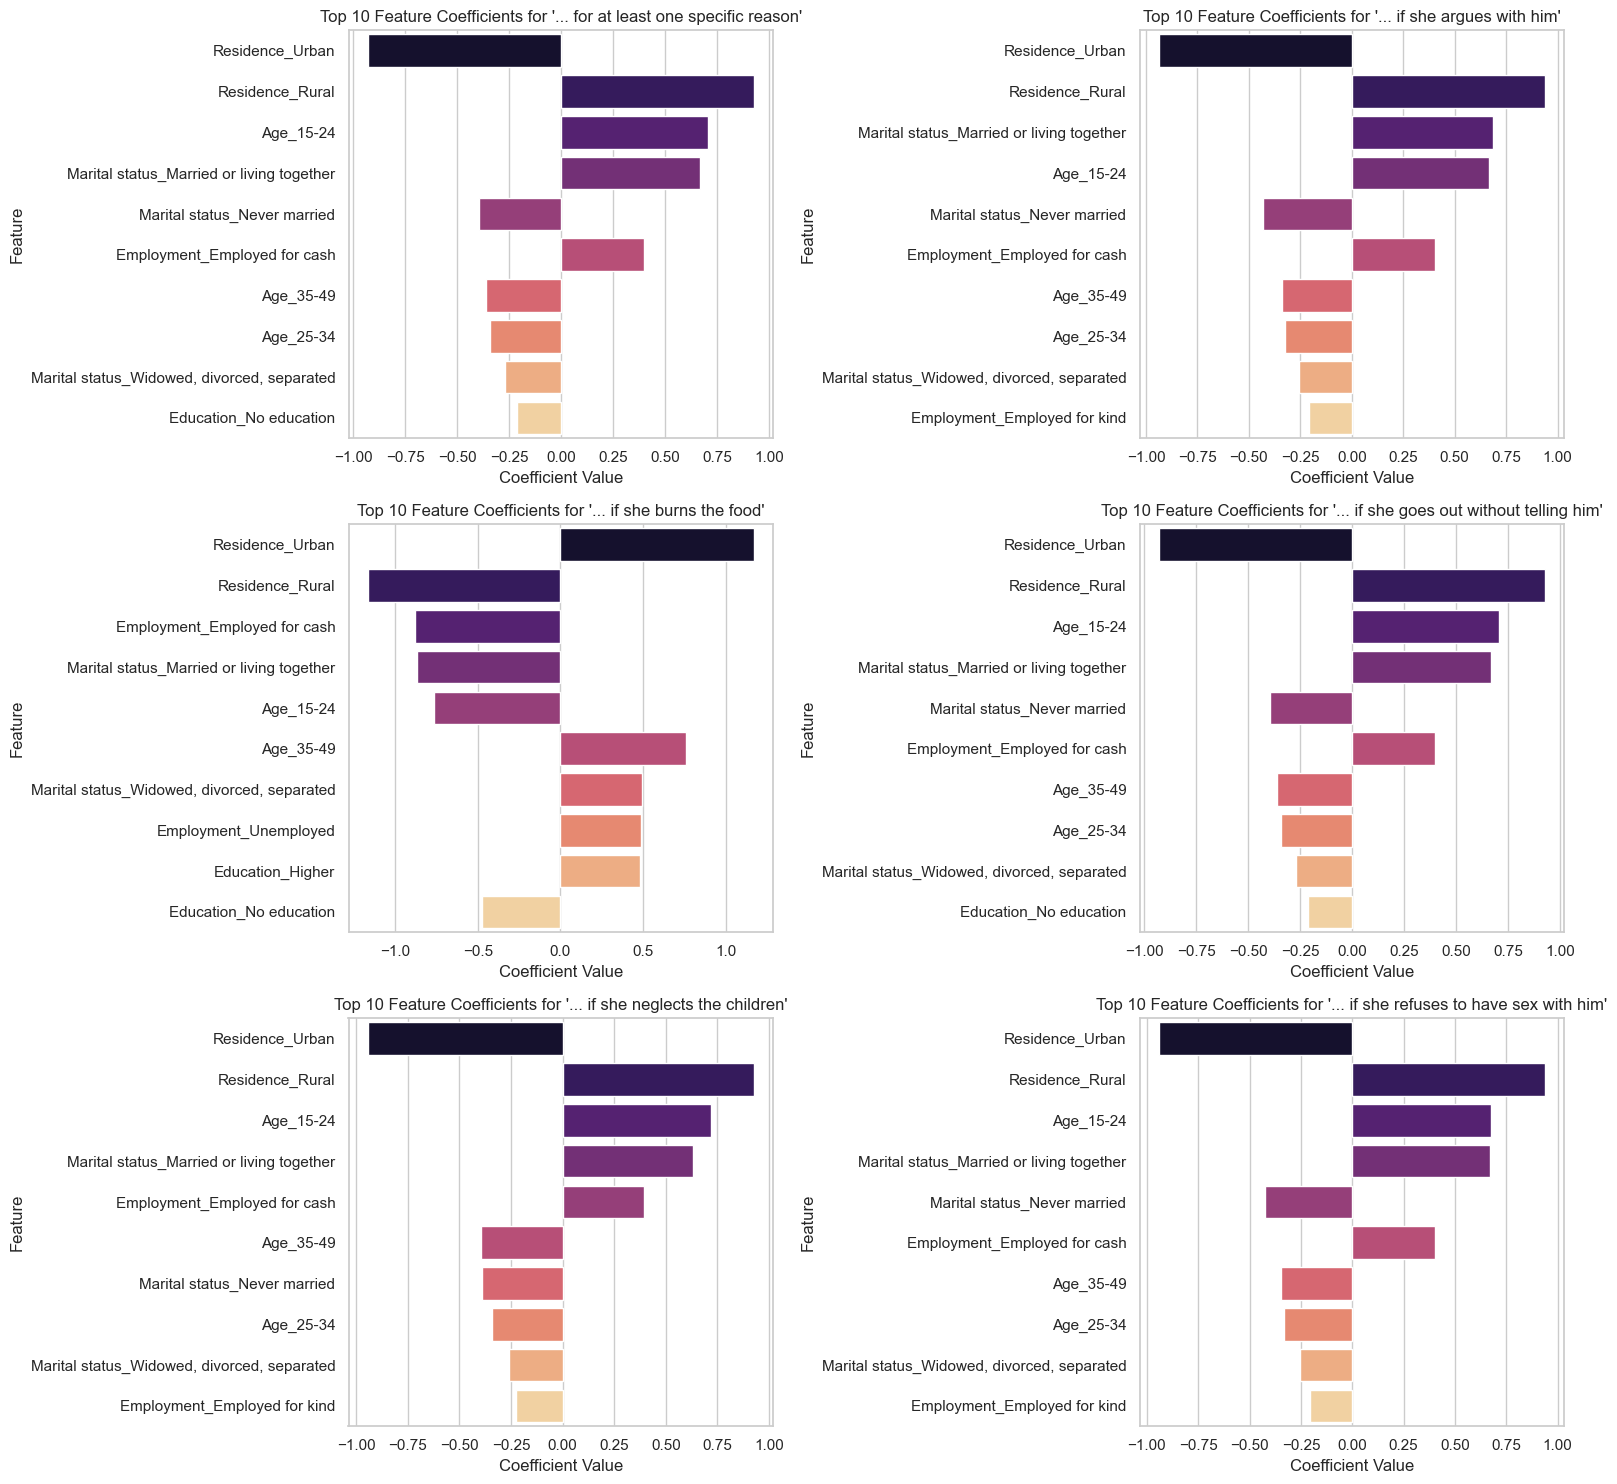

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

n_questions = len(results_list)

n_cols = 2
n_rows = (n_questions + n_cols - 1) // n_cols  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
axes = axes.flatten()  

for i, res in enumerate(results_list):
    ax = axes[i]
    if res['coefficients'] is not None:
        top_idx = np.argsort(np.abs(res['coefficients']))[::-1][:10]
        sns.barplot(
            x=res['coefficients'][top_idx],
            y=res['feature_names'][top_idx],
            palette="magma",
            dodge=False,
            ax=ax
        )
        ax.set_title(f"Top 10 Feature Coefficients for '{res['question']}'")
        ax.set_xlabel("Coefficient Value")
        ax.set_ylabel("Feature")

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig("all_feature_importances.jpg", dpi=300)
plt.show()


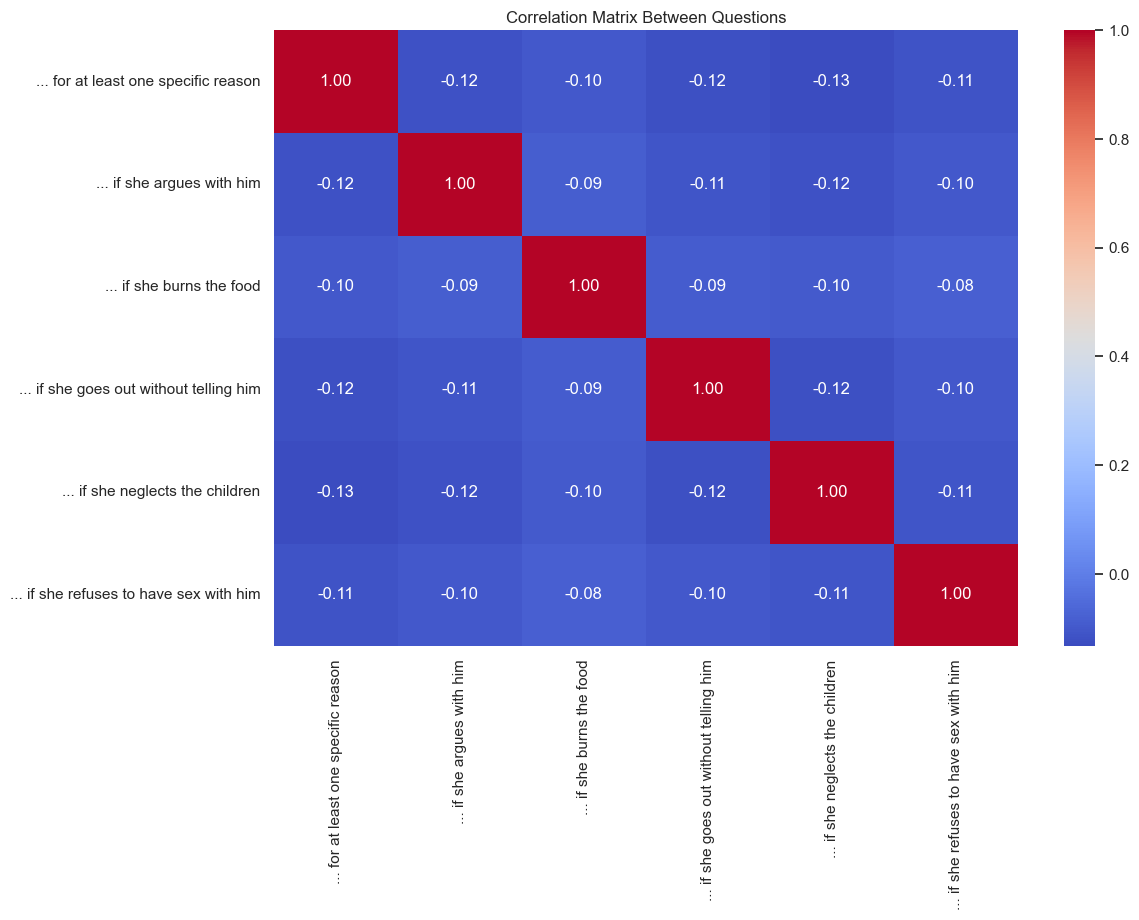

In [ ]:
plt.figure(figsize=(12,8))
corr_matrix = full_df[question_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Between Questions")
plt.show()

In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  

file_path = "Violence Against Women  Girls Data.csv" 
df = pd.read_csv(file_path) 

df['Survey Year'] = pd.to_datetime(df['Survey Year'], errors='coerce') 
df['Year'] = df['Survey Year'].dt.year 
df = df.drop(columns=['Survey Year']) 


demo_pivot = df.pivot_table(
    index=['RecordID', 'Country', 'Gender', 'Year', 'Question'], 
    columns='Demographics Question', 
    values='Demographics Response', 
    aggfunc='first'
).reset_index() 
demo_pivot.columns.name = None 
demo_pivot = demo_pivot.drop(columns=['Question']) 


value_pivot = df.pivot_table(
    index=['RecordID', 'Country', 'Gender', 'Year'], 
    columns='Question', 
    values='Value', 
    aggfunc='first'
).reset_index() 
value_pivot.columns.name = None 


full_df = pd.merge(
    demo_pivot, value_pivot, 
    on=['RecordID', 'Country', 'Gender', 'Year'], 
    how='left'
) 
full_df = full_df.drop(columns=['RecordID', 'Year', 'Country']) 


question_cols = value_pivot.columns[4:] 
predictor_cols = full_df.columns.difference(question_cols) 

full_df[predictor_cols] = full_df[predictor_cols].fillna(0) 
full_df[question_cols] = full_df[question_cols].fillna(0)


def create_balanced_binary_target(values):
    threshold = np.median(values)
    binary = (values > threshold).astype(int)
    return binary, threshold

y_binary = pd.DataFrame(index=full_df.index, columns=question_cols)
thresholds = {}

for q in question_cols:
    y_binary[q], thresholds[q] = create_balanced_binary_target(full_df[q].values)
    ratio = y_binary[q].mean()
    print(f"{q} → Threshold: {thresholds[q]:.2f}, Class balance (fraction 1s): {ratio:.2f}")

categorical_cols = full_df[predictor_cols].select_dtypes(include='object').columns.tolist()
numeric_cols = full_df[predictor_cols].select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

results_list = []

for q in question_cols:
    X = full_df[predictor_cols]
    y = y_binary[q]
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42
        )
    model_pipeline = ImbPipeline([
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('logreg', LogisticRegression(max_iter=500))
    ])

    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    y_proba = model_pipeline.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(y_test, y_proba)
    except ValueError:
        roc_auc = np.nan

    num_features = numeric_cols
    cat_features = model_pipeline.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names = np.concatenate([num_features, cat_features])
    coefficients = model_pipeline.named_steps['logreg'].coef_.flatten()

    results_list.append({
        'question': q,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'threshold_used': thresholds[q],
        'feature_names': feature_names,
        'coefficients': coefficients,
        'y_pred': y_pred
    })

results_df = pd.DataFrame(results_list)

print("\nClassification metrics for each question:")
print(results_df[['question','accuracy','precision','recall','f1_score','roc_auc']])

print("\nTarget balance for all questions:")
for q in question_cols:
    counts = y_binary[q].value_counts()
    ratio = y_binary[q].mean()
    print(f"{q} → 0s: {counts.get(0,0)}, 1s: {counts.get(1,0)}, fraction of 1s: {ratio:.2f}")


... for at least one specific reason → Threshold: 0.00, Class balance (fraction 1s): 0.15
... if she argues with him → Threshold: 0.00, Class balance (fraction 1s): 0.15
... if she burns the food → Threshold: 0.00, Class balance (fraction 1s): 0.14
... if she goes out without telling him → Threshold: 0.00, Class balance (fraction 1s): 0.15
... if she neglects the children → Threshold: 0.00, Class balance (fraction 1s): 0.15
... if she refuses to have sex with him → Threshold: 0.00, Class balance (fraction 1s): 0.15

Classification metrics for each question:
                                  question  accuracy  precision    recall  \
0     ... for at least one specific reason  0.228571   0.164948  1.000000   
1               ... if she argues with him  0.514286   0.161905  0.548387   
2                ... if she burns the food  0.909524   0.812500  0.448276   
3  ... if she goes out without telling him  0.228571   0.164948  1.000000   
4         ... if she neglects the children  0.22857